In [1]:
import os
import tridy
from tridy import GeoConcept, SubGeoConcept, MetaData, Table, View, DBStorage, DataSource, Feature, FeatureWithID,  AdmUnitFeature, OLUFeature, Grid, Imagee, ds_from_metadata, xml_lpis_cz_reader, lpis_cz__posledni_aktualizace, get_listvalues_from_generator, apply_function, select_nodes_from_graph, unzip_file, find_neighbors_till, connection_parameters_to_pg, transform_name_to_postgresql_format, world_to_pixel 
from importlib import reload
import requests
import datetime
import re
from io import BytesIO

from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

from osgeo import ogr, osr, gdal
import networkx as nx
import numpy as np
import json
import binascii
import copy
import time

from lxml import etree

In [2]:
del(GeoConcept, SubGeoConcept, MetaData, Table, View, DBStorage, DataSource, Feature, FeatureWithID, AdmUnitFeature, OLUFeature, Grid, Imagee, ds_from_metadata,xml_lpis_cz_reader,get_listvalues_from_generator,apply_function,select_nodes_from_graph,world_to_pixel)
reload(tridy)
from tridy import GeoConcept, SubGeoConcept, MetaData, Table, View, DBStorage, DataSource, Feature, FeatureWithID, AdmUnitFeature, OLUFeature, Grid, Imagee, ds_from_metadata, xml_lpis_cz_reader, get_listvalues_from_generator, apply_function, select_nodes_from_graph,world_to_pixel

In [3]:
class Theme():
    ''''popis pasportu objektu'''
    def __init__(self, name, description,  attributes):
        self._name=name
        self._description=description
        self._attributes=attributes
    def get_name(self):
        return self._name
    def get_description(self):
        return self._description
    def get_attributes(self):
        return self._attributes
    def set_geometry_order(self, geoconcepts):
        self._geometry_order=geoconcepts
    def get_geometry_order(self):
        return self._geometry_order
    def set_attribute_order(self, geoconcepts):
        self._attribute_order=geoconcepts
    def get_attribute_order(self):
        return self._attribute_order
    def set_dictionary(self, dictionary):
        self._dictionary=dictionary
    def get_dictionary(self):
        return self._dictionary
    def transform(self,dictionary_key):
        concept=apply_function(self._dictionary,dictionary_key)
        return concept
    '''def transform(self, transformation_dictionary, level=None, fill_all=False):
        if level is not None:
            if self._geometry_order[0].get_type()=='spatial:admin':
                level_objects=level.read_features()# precist vsechny prvky, napriklad, z urovne Obce anebo KatastralniUzemi
                for level_object in level_objects:
                    features=self._geometry_order[0].find_subconcept_by_name(level_object.get_name()).read_features()
                    transform_features # mozna najit zpusob a aplikovat transformaci za cteni
                    write_features_to_the_table
            geometry_subgeoconcepts=self._geometry_order[0].get_subgeoconcepts()
            attributes_subgeoconcepts=self._attribute._order[0].get_subgeoconcepts()
            if geometry_subgeoconcepts.
        for level_object in level_objects :
            
            geoconcept with the highest priority select features from db from this level
            for features from selected geoconcept:
                transform selected features according to the provided transformation_dictionary
                add transformed feature to the return list
            yield(subgeoconcept, list)'''

In [4]:
def compilable_tree_dictionary(object): 
    g_dict=\
    {'admunit':{'object':object},\
    'admunit__tree':{'object':'admunit','function':'return_graph_representation'},\
    'admunit__tree__reverse':{'object':'admunit__tree','function':'reverse'},\
    'admunit__tree__level3':{'function':select_nodes_from_graph,'parameters':['admunit__tree','level',3]},\
    'admunit__tree__level4':{'function':select_nodes_from_graph,'parameters':['admunit__tree','level',4]}}
    return g_dict

In [5]:
def compilable_node_dictionary(object,node__level=0,node__name='1'): 
    g_dict=\
    {'admunit':{'object':object},\
    'admunit__tree':{'object':'admunit','function':'return_graph_representation'},\
    'admunit__tree__reverse':{'object':'admunit__tree','function':'reverse'},\
    'node__level':{'object':node__level},\
    'node__name':{'object':node__name},\
    'admunit__tree__level':{'function':select_nodes_from_graph,'parameters':['admunit__tree','level','node__level']},\
    'admunit__tree__neighbors':{'function':find_neighbors_level,'parameters':['admunit__tree','node__name','node__level']},\
    'admunit__tree__neighbors__43__4':{'function':find_neighbors_level,'parameters':['admunit__tree__reverse','43',4]},\
    'admunit__tree__neighbors__43__3':{'function':find_neighbors_level,'parameters':['admunit__tree__reverse','43',3]},\
    }
    return g_dict

In [6]:
def find_neighbors_level(graph,start_node,level):
    if graph.nodes()[start_node]['level']==level:
        yield start_node
    else:
        for n in graph.neighbors(start_node):
            yield from find_neighbors_level(graph,n,level) 

In [7]:
def raster_value(point,transformation,raster):
    point.Transform(transformation)
    return raster.get_data()[tuple(np.flip(world_to_pixel(raster.get_metadata()['affine_transformation'],point.GetX(),point.GetY())))]

In [8]:
def get_ruian_au_feature_geometry_from_wfs(gml_id):
    url='https://services.cuzk.cz/wfs/inspire-au-wfs.asp?service=WFS&request=GetFeature&typeName=au:AdministrativeUnit&maxFeatures=1&featureID=%s&version=2.0.0' %gml_id
    r=requests.get(url,stream=False)
    if r.status_code==200:
        tree=etree.parse(BytesIO(r.content))
        root=tree.getroot()
        geom=root.find('.//{http://www.opengis.net/gml/3.2}MultiSurface')
        geom_ogr=ogr.CreateGeometryFromGML(etree.tostring(geom).decode())
        return geom_ogr.ExportToWkt()
    else:
        return 'WFS no works'

In [9]:
#for the case when data has to be downloaded externally initialization of requests session variable with setting of number of retries
s = requests.Session()
retries = Retry(total=5, backoff_factor=1, status_forcelist=[ 502, 503, 504 ])
s.mount('http://', HTTPAdapter(max_retries=retries))

In [10]:
replacement_dictionary = {"[posledni_den_mesice]":(datetime.datetime.today().replace(day=1)-datetime.timedelta(days=1)).strftime('%Y%m%d'),"[lpis_cz__posledni_aktualizace]":lpis_cz__posledni_aktualizace().strftime('%Y%m%d'), "[vcera]":(datetime.datetime.today().replace(day=1)-datetime.timedelta(days=1)).strftime('%Y%m%d')} 
json_feature_structure=[{"name":"id","type":"serial primary key"},{"name":"geom","type":"geometry"},{"name":"data","type":"json"}]
json_feature_with_bigid_structure=[{"name":"id","type":"bigint primary key"},{"name":"geom","type":"geometry"},{"name":"data","type":"json"}]
json_admin_unit_structure=[{"name":"id","type":"integer primary key"},{"name":"geom","type":"geometry"},{"name":"data","type":"json"},{"name":"level","type":"integer"},{"name":"parent_id","type":"text"}]
json_admin_unit_structure_at=[{"name":"id","type":"text primary key"},{"name":"geom","type":"geometry"},{"name":"data","type":"json"},{"name":"level","type":"integer"},{"name":"parent_id","type":"text"}]
json_feature_with_raster_structure=[{"name":"id","type":"serial primary key"},{"name":"geom","type":"geometry"},{"name":"data","type":"json"},{"name":"raster_maps","type":"raster"}]

In [11]:
admunit_cz__metadata=MetaData('Administrative units in Czech Republic',
                              {"url":"https://vdp.cuzk.cz/vymenny_format/soucasna/[posledni_den_mesice]_ST_UKSG.xml.zip",
                               "format":"GML", "compression":"zip"},'data')

In [12]:
admunit_cz__ds=ds_from_metadata(admunit_cz__metadata)
admunit_cz=GeoConcept('Administrative units in Czech Republic','Administrative units in Czech Republic. All levels.',
                      'AdmUnitFeature',json_admin_unit_structure, data_source=admunit_cz__ds, subgeoconcepts=[] )

In [13]:
url_adresa=admunit_cz.get_data_source().get_attributes()['url']
for i in re.findall('\[.*?\]',url_adresa):
    if i in list(replacement_dictionary.keys()):
        url_adresa=url_adresa.replace(i,replacement_dictionary[i])
        
admunit_cz.get_data_source().set_attribute({'url':url_adresa})
del(url_adresa)

In [14]:
#admunit_cz.get_data_source().download_data('archive.zip',s,'all',os.getcwd())
admunit_cz.get_data_source().set_data_file('20201031_ST_UKSG.xml')

In [15]:
concept_list=['Staty','Vusc','Okresy','Obce','KatastralniUzemi']
concept_additional_attributes={'Staty':{'level_value':0,'parent_value':'null','id_attribute':'Kod'},
                               'Vusc':{'level_value':1,'parent_value':'1','id_attribute':'Kod'},
                               'Okresy':{'level_value':2,'parent_attribute':'VuscKod','id_attribute':'Kod'},
                               'Obce':{'level_value':3,'parent_attribute':'OkresKod','id_attribute':'Kod'},
                               'KatastralniUzemi':{'level_value':4,'parent_attribute':'ObecKod','id_attribute':'Kod'}}

In [16]:
for l in list(set(concept_list).intersection(set(admunit_cz.get_data_source().list_layers()))):
    admunit_cz.append_subgeoconcept(SubGeoConcept(l,l,'AdmUnitFeature',admunit_cz.get_attributes(),data_source=DataSource(admunit_cz.get_data_source().get_type(),admunit_cz.get_data_source().get_name(),({**admunit_cz.get_data_source().get_attributes(),**{'layer':l}}),None,admunit_cz.get_data_source().get_data_file()),supergeoconcept=admunit_cz,table_inheritance=False,type='semantic',subgeoconcepts=[]))

In [17]:
#administrative territorial units
dbs_admin_connection={'dbname':'olu_administrative_units','user':'euxdat_admin','host':'euxdat-db-svc','port':'5432','password':'Euxdat12345'}
dbs_admin=DBStorage(dbs_admin_connection)
dbs_admin.connect()
dbs_admin.disconnect()
dbs_admin.connect()

#lpis in czech republic
dbs_lpis_cz_connection={'dbname':'lpis_cz','user':'euxdat_admin','host':'euxdat-db-svc','port':'5432','password':'Euxdat12345'}
dbs_lpis_cz=DBStorage(dbs_lpis_cz_connection)
dbs_lpis_cz.connect()
dbs_lpis_cz.disconnect()
dbs_lpis_cz.connect()

#ruian cadastral parcels in czech republic
dbs_ruian_parcely_cz_connection={'dbname':'ruian_parcely_cz','user':'euxdat_admin','host':'euxdat-db-svc','port':'5432','password':'Euxdat12345'}
dbs_ruian_parcely_cz=DBStorage(dbs_ruian_parcely_cz_connection)
dbs_ruian_parcely_cz.connect()
dbs_ruian_parcely_cz.disconnect()
dbs_ruian_parcely_cz.connect()

In [20]:
#to get statistics
#dbs_admin.execute('SELECT pg_database.datname, pg_size_pretty(pg_database_size(pg_database.datname)) AS size FROM pg_database;')

In [21]:
#dbs_admin.execute('create schema cz')
#dbs_admin.execute('create extension postgis')
#dbs_lpis_cz.execute('create schema data')
#dbs_lpis_cz.execute('create extension postgis')
#dbs_ruian_parcely_cz.execute('create schema data')
#dbs_ruian_parcely_cz.execute('create extension postgis')

In [22]:
admunit_cz.create_table(dbs_admin, name='default',scheme='cz',conflict='append')

In [109]:
#for sub in admunit_cz.get_subgeoconcepts():
#    features=sub.get_data_source().read_features('admunitfeature',concept_additional_attributes[sub.get_data_source().get_attributes()['layer']],number=10)
#    dbs_admin.insert_many('insert into %s.%s (geom,data,id,level,parent_id) ' % (admunit_cz.get_table().get_scheme(),admunit_cz.get_table().get_name()) ,features,20)

In [110]:
for sub in admunit_cz.get_subgeoconcepts():
    sub.set_table(View(sub.get_name(),sub.get_attributes(), sub.get_supergeoconcept().get_table(),"level=%s" % (concept_additional_attributes[sub.get_name()]['level_value']), dbs=dbs_admin, scheme='public', type='usual'))
    dbs_admin.execute(sub.get_table().create_script())

In [22]:
'''for i in admunit_cz.read_features_from_table(number=100):
    if len(i)>0:
        for j in i:
            if j.get_level()==3:
                try:
                    dbs_admin.execute("update %s.%s set geom=st_geomfromtext('%s') where data->>'gml_id'='%s'" % (admunit_cz.get_table().get_scheme(),admunit_cz.get_table().get_name(),get_ruian_au_feature_geometry_from_wfs(j.get_data()['gml_id']),j.get_data()['gml_id']) )
                except:
                    dbs_admin.disconnect()
                    dbs_admin.connect()
                    print(j.get_data()['gml_id'])
    else:
        break'''

'for i in admunit_cz.read_features_from_table(number=100):\n    if len(i)>0:\n        for j in i:\n            if j.get_level()==3:\n                try:\n                    dbs_admin.execute("update %s.%s set geom=st_geomfromtext(\'%s\') where data->>\'gml_id\'=\'%s\'" % (admunit_cz.get_table().get_scheme(),admunit_cz.get_table().get_name(),get_ruian_au_feature_geometry_from_wfs(j.get_data()[\'gml_id\']),j.get_data()[\'gml_id\']) )\n                except:\n                    dbs_admin.disconnect()\n                    dbs_admin.connect()\n                    print(j.get_data()[\'gml_id\'])\n    else:\n        break'

In [23]:
lpis_cz__metadata=MetaData('LPIS in Czech Republic',
                              [{"url":"http://eagri.cz/public/app/eagriapp/lpisdata/[lpis_cz__posledni_aktualizace]-{admunit__tree__level4}-DPB-SHP.zip",
                               "format":"SHP", "compression":"zip"},{"url":"http://eagri.cz/public/app/eagriapp/lpisdata/[lpis_cz__posledni_aktualizace]-{admunit__tree__level4}-DPB-XML-A.zip",
                               "format":"XML", "compression":"zip"}],'data')
lpis_cz__ds_xml=ds_from_metadata(lpis_cz__metadata,format='XML')
lpis_cz=GeoConcept('LPIS in Czech Republic','LPIS in Czech Republic. All levels.',
                      'Feature',json_feature_structure, data_source=lpis_cz__ds_xml, subgeoconcepts=[], adm_graph_node='1')

In [24]:
lpis_cz.create_table(dbs_lpis_cz,name='default',scheme='public',conflict='append')

In [25]:
url_adresa=lpis_cz.get_data_source().get_attributes()['url']
for i in re.findall('\[.*?\]',url_adresa):
    if i in list(replacement_dictionary.keys()):
        url_adresa=url_adresa.replace(i,replacement_dictionary[i])
lpis_cz.get_data_source().set_attribute({'url':url_adresa})
del(url_adresa)

In [26]:
for i in re.findall('\{.*?\}',lpis_cz.get_data_source().get_attributes()['url']): 
    if i[1:-1] in list(compilable_tree_dictionary(admunit_cz).keys()):
        for j in apply_function(compilable_tree_dictionary(admunit_cz),i[1:-1]):
            lpis_cz.append_subgeoconcept(SubGeoConcept(str(j),'LPIS in Czech administrative territorial unit %s ' % str(j),'Feature',lpis_cz.get_attributes(),data_source=DataSource(lpis_cz.get_data_source().get_type(),lpis_cz.get_data_source().get_name(),(dict(lpis_cz.get_data_source().get_attributes(),**{'url':lpis_cz.get_data_source().get_attributes()['url'].replace(i,str(j))})),None,None),supergeoconcept=lpis_cz,table_inheritance=True,subgeoconcepts=[],type='spatial:admin',adm_graph_node=str(j)))

In [27]:
for sub in lpis_cz.get_subgeoconcepts():
    #sub.get_data_source().download_data('archive.zip',s,'all',os.getcwd())
    #sub.create_table(dbs_lpis_cz,name=sub.get_name(),scheme='data',conflict='replace')
    #features=sub.get_data_source().read_features('feature',number=10,reader=xml_lpis_cz_reader)
    #dbs_lpis_cz.insert_many('insert into %s (geom,data) ' % (transform_name_to_postgresql_format(sub.get_table().get_scheme())+'.'+transform_name_to_postgresql_format(sub.get_table().get_name())) ,features,20)
    #os.remove(sub.get_data_source().get_data_file())
    sub.create_table(dbs_lpis_cz,name=sub.get_name(),scheme='data',conflict='append',adm_graph_node=sub.get_adm_graph_node())

In [28]:
ruian_cz__metadata=MetaData('RUIAN in Czech Republic',
                              {"url":"https://vdp.cuzk.cz/vymenny_format/soucasna/[vcera]_OB_{admunit__tree__level3}_UKSH.xml.zip",
                               "format":"GML", "compression":"zip"},'data')
ruian_parcely_cz__ds=ds_from_metadata(ruian_cz__metadata)
ruian_parcely_cz__ds.set_attributes({**ruian_parcely_cz__ds.get_attributes(),**{'layer':'Parcely'}})
ruian_parcely_cz=GeoConcept('Land parcels in Czech Republic','Digital land parcels (parcely) in Czech Republic.',
                      'FeatureWithID',json_feature_with_bigid_structure, data_source=ruian_parcely_cz__ds,subgeoconcepts=[],adm_graph_node='1')

In [29]:
url_adresa=ruian_parcely_cz.get_data_source().get_attributes()['url']
for i in re.findall('\[.*?\]',url_adresa):
    if i in list(replacement_dictionary.keys()):
        url_adresa=url_adresa.replace(i,replacement_dictionary[i])
ruian_parcely_cz.get_data_source().set_attribute({'url':url_adresa})
del(url_adresa)

In [30]:
ruian_parcely_cz.create_table(dbs_ruian_parcely_cz, name='default',scheme='public',conflict='append',adm_graph_node='1')

In [31]:
concept_list=['Parcely']
concept_additional_attributes={'Parcely':{'id_attribute':'Id'}}

for i in re.findall('\{.*?\}',ruian_parcely_cz.get_data_source().get_attributes()['url']): 
    if i[1:-1] in list(compilable_tree_dictionary(admunit_cz).keys()):
        for j in apply_function(compilable_tree_dictionary(admunit_cz),i[1:-1]):
            ruian_parcely_cz.append_subgeoconcept(SubGeoConcept('ob_%s' % str(j),'RUIAN land parcels in Czech administrative territorial unit %s ' % str(j),'FeatureWithID',ruian_parcely_cz.get_attributes(),data_source=DataSource(ruian_parcely_cz.get_data_source().get_type(),ruian_parcely_cz.get_data_source().get_name(),(dict(ruian_parcely_cz.get_data_source().get_attributes(),**{'url':ruian_parcely_cz.get_data_source().get_attributes()['url'].replace(i,str(j))})),None,None),supergeoconcept=ruian_parcely_cz,table_inheritance=True,subgeoconcepts=[],adm_graph_node=str(j)))

In [32]:
len(ruian_parcely_cz.get_subgeoconcepts())

6258

In [33]:
for sub in ruian_parcely_cz.get_subgeoconcepts():
    #sub.get_data_source().download_data('archive.zip',s,'all',os.getcwd())
    #sub.create_table(dbs_ruian_parcely_cz,name='default',scheme='data',conflict='replace')
    #features=sub.get_data_source().read_features('featurewithid', concept_additional_attributes[sub.get_data_source().get_attributes()['layer']], number=100, gfs_template='sablona.gfs')
    #dbs_ruian_parcely_cz.insert_many('insert into %s (geom,data,id) ' % (transform_name_to_postgresql_format(sub.get_table().get_scheme())+'.'+transform_name_to_postgresql_format(sub.get_table().get_name())) ,features,100)
    #os.remove(sub.get_data_source().get_data_file())
    sub.create_table(dbs_ruian_parcely_cz,name='default',scheme='data',conflict='append',adm_graph_node=sub.get_adm_graph_node())

In [34]:
dbs_ruian_parcely_cz.execute('select count(*) from %s' % ruian_parcely_cz.get_table().get_name() )

[(22667501,)]

In [35]:
def compilable_theme_dem_dictionary(dem_image_object,ruian_parcely_object=None,lpis_object=None,urbanatlas_object=None,corine_object=None): 
    g_dict=\
    {'ruian_parcely_object':{'object':ruian_parcely_object},\
     'lpis_object':{'object':lpis_object},\
     'urbanatlas_object':{'object':urbanatlas_object},\
     'corine_object':{'object':corine_object},\
     'dem_image_object':{'object':dem_image_object},\
     'ruian_parcely_object__id':{'object':'ruian_parcely_object','function':'get_id'},\
     'ruian_parcely_object__geometry':{'object':'ruian_parcely_object','function':'get_geometry'},\
     'ruian_parcely_object__data':{'object':'ruian_parcely_object','function':'get_data'},\
     'ruian_parcely_object__raster_data':{'object':'ruian_parcely_object','function':'get_raster_map','parameters':['dem_image_object']},\
     'lpis_object__id':{'object':'ruian_parcely_object','function':'get_id'},\
     'lpis_object__geometry':{'object':'ruian_parcely_object','function':'get_geometry'},\
     'lpis_object__data':{'object':'ruian_parcely_object','function':'get_data'},\
     
    'admunit__tree':{'object':'admunit','function':'return_graph_representation'},\
    'admunit__tree__reverse':{'object':'admunit__tree','function':'reverse'},\
    'node__level':{'object':node__level},\
    'node__name':{'object':node__name},\
    'admunit__tree__level':{'function':select_nodes_from_graph,'parameters':['admunit__tree','level','node__level']},\
    'admunit__tree__neighbors':{'function':find_neighbors_level,'parameters':['admunit__tree','node__name','node__level']},\
    'admunit__tree__neighbors__43__4':{'function':find_neighbors_level,'parameters':['admunit__tree__reverse','43',4]},\
    'admunit__tree__neighbors__43__3':{'function':find_neighbors_level,'parameters':['admunit__tree__reverse','43',3]},\
    'admunit__tree__neighbors__19__3':{'function':find_neighbors_level,'parameters':['admunit__tree__reverse','19',3]},\
    }
    return g_dict

In [36]:
def lpis_transformations(object,additional_properties): 
    o_dict=\
    {'feature':{'object':object},\
     'additional_properties':{'object':additional_properties},\
     'id':{'function':(lambda y: y.get_id() if type(y)!=Feature else int(y.get_data()['IDDPB'])),'parameters':['feature']},\
     'geom':{'function':(lambda y: y.get_geometry()),'parameters':['feature']},\
     'properties':{'function':(lambda y,z: {**{'HILUCS_VALUE':lpis_hilucs[y.get_data()['KULTURAID']],'BPEJ':y.get_data()['BPEJ'],'OPATRENIEROZE2G':y.get_data()['OPATRENIEROZE2G']},**{k: v for d in z for k, v in d.items()}}),'parameters':['feature','additional_properties']},
    }
    return o_dict

In [37]:
dem30_fn='dem30/eu_dem_czat3035.tif'
dem30=gdal.Open(dem30_fn)

In [38]:
wgs84_sr=osr.SpatialReference()
wgs84_sr.ImportFromProj4('+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs')

0

In [39]:
sjtsk5514_sr=osr.SpatialReference()
sjtsk5514_sr.ImportFromProj4('+proj=krovak +lat_0=49.5 +lon_0=24.83333333333333 +alpha=30.28813972222222 +k=0.9999 +x_0=0 +y_0=0 +ellps=bessel +towgs84=589,76,480,0,0,0,0 +units=m +no_defs')

0

In [40]:
etrs3035_sr=osr.SpatialReference()
etrs3035_sr.ImportFromProj4('+proj=laea +lat_0=52 +lon_0=10 +x_0=4321000 +y_0=3210000 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs')

0

In [41]:
#sjtsk5514_to_wgs84=osr.CoordinateTransformation(sjtsk5514_sr,wgs84_sr)
sjtsk5514_to_etrs3035=osr.CoordinateTransformation(sjtsk5514_sr,etrs3035_sr)

In [42]:
metadata_dict={}
metadata_dict['affine_transformation']=dem30.GetGeoTransform()
metadata_dict['nodata']=dem30.GetRasterBand(1).GetNoDataValue()
metadata_dict['proj_wkt']=etrs3035_sr.ExportToWkt()

In [81]:
features=admunit_cz.get_subgeoconcepts()[1].read_features_from_table(1)

In [82]:
feature=next(features)[0]

In [45]:
feature_geometry3035=ogr.CreateGeometryFromWkb(binascii.unhexlify(feature.get_geometry()))

In [46]:
feature_geometry3035.Transform(sjtsk5514_to_etrs3035)

0

In [47]:
grid=Grid((metadata_dict['affine_transformation'][0],metadata_dict['affine_transformation'][3]),(metadata_dict['affine_transformation'][1],metadata_dict['affine_transformation'][5]))

In [48]:
grid.get_gridorigin()

(4284025.866235667, 3142928.7893613447)

In [49]:
feature_geometry3035.GetEnvelope()

(4857490.640853093, 4859047.039474186, 2959743.5323213856, 2961235.1986777917)

In [50]:
origin=tuple(grid.find_index((feature_geometry3035.GetEnvelope()[0],feature_geometry3035.GetEnvelope()[3])))

In [51]:
size=tuple(np.array(grid.find_index((feature_geometry3035.GetEnvelope()[1],feature_geometry3035.GetEnvelope()[2])))-np.array(grid.find_index((feature_geometry3035.GetEnvelope()[0],feature_geometry3035.GetEnvelope()[3]))))+np.array([1,1])

In [52]:
a=np.array(dem30.GetRasterBand(1).ReadAsArray(xoff=int(origin[0]),yoff=int(origin[1]),win_xsize=int(size[0]),win_ysize=int(size[1])))

In [53]:
grid_clip=Grid(np.array(grid.get_gridorigin())+np.array(tuple(grid.find_index((feature_geometry3035.GetEnvelope()[0],feature_geometry3035.GetEnvelope()[3]))))*np.array(grid.get_gridstepsize()),(metadata_dict['affine_transformation'][1],metadata_dict['affine_transformation'][5]))

In [54]:
clip_metadata_dict={}
clip_metadata_dict['affine_transformation']=grid_clip.get_affinetransformation()
clip_metadata_dict['nodata']=float(np.min(a)) if np.min(a)<0 else np.nan
clip_metadata_dict['proj_wkt']=wgs84_sr.ExportToWkt()

In [55]:
im=Imagee(a,clip_metadata_dict)

In [56]:
im.export_as_tif('obec_testovaci4.tif')

In [57]:
from tridy import find_neighbors_till

In [58]:
G=apply_function(compilable_tree_dictionary(admunit_cz),'admunit__tree')

In [59]:
features_lpis=lpis_cz.get_subgeoconcept_by_name(find_neighbors_till(G.reverse(),str(feature.get_data()['Kod']),lpis_cz).get_name()).read_features_from_table(1)
feature_lpis=next(features_lpis)[0]

In [60]:
feature_lpis_geometry3035=ogr.CreateGeometryFromWkb(binascii.unhexlify(feature_lpis.get_geometry()))

In [61]:
feature_lpis_geometry3035.Transform(sjtsk5514_to_etrs3035)

0

In [62]:
cropped_im=Imagee(*im.clip_by_shape(feature_lpis_geometry3035.ExportToWkt()))

In [63]:
cropped_im.export_as_tif('pole.tif')

In [64]:
feature_lpis_geometry3035.ExportToWkt()

'POLYGON ((4858809.5818415 2960519.87267249,4858813.55929396 2960518.83428455,4858854.37073578 2960526.31180962,4858854.86943959 2960535.08548206,4858852.5630925 2960561.05142441,4858851.95431875 2960579.50087598,4858850.24435335 2960594.25986388,4858849.09330171 2960599.53908937,4858846.00151345 2960604.32672044,4858841.02393389 2960604.75618918,4858839.36484617 2960611.56611195,4858837.25774875 2960621.14328507,4858832.66998894 2960639.10018583,4858817.91174113 2960638.48481796,4858808.7594976 2960638.13682503,4858808.7155873 2960633.98583765,4858809.5818415 2960519.87267249))'

In [65]:
cropped_im.get_data()

masked_array(
  data=[[304.62237548828125, 302.64471435546875],
        [305.71270751953125, 304.05078125],
        [306.84521484375, 305.47772216796875],
        [307.74371337890625, 306.5793151855469],
        [308.298583984375, 307.2650146484375]],
  mask=[[False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False]],
  fill_value=1e+20)

In [66]:
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

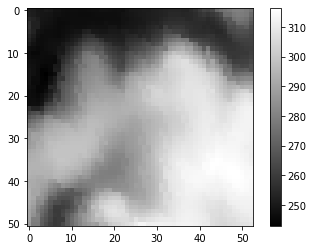

In [67]:
plt.imshow(im.get_data(), origin="upper", cmap='gray', interpolation='nearest')
plt.colorbar()
plt.show()

In [83]:
sub=lpis_cz.get_subgeoconcept_by_name(find_neighbors_till(G.reverse(),str(feature.get_data()['Kod']),lpis_cz).get_name())

In [114]:
with open('okresy.geojson', 'w', encoding='utf-8') as file:
        geojson={"type": "FeatureCollection", "features": [] }
        features=sub.read_features_from_table(100)
        for f in features:
                if len(f)>0:
                    for feature in f:
                        geojson["features"].append(feature.export_to_geojson())
                else:
                    break
        json.dump(geojson, file, ensure_ascii=False, indent=4)

In [89]:
import skimage

In [121]:
#dem30_im=Imagee(np.array(dem30.GetRasterBand(1).ReadAsArray()),metadata_dict)

In [160]:
#from tridy import download_file,unzip_file

In [162]:
#download_file('http://gis.lesprojekt.cz/eu_dem_czat3035.zip','eu_dem_czat3035.zip',s)

'eu_dem_czat3035.zip'

In [164]:
#unzip_file('eu_dem_czat3035.zip','all','dem30')

In [113]:
sub=admunit_cz.get_subgeoconcept_by_name('Okresy')